In [31]:
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

# Matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns

sns.set(font_scale = 2)

# Imputing missing values
from sklearn.preprocessing import Imputer, MinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

from sklearn import tree

# LIME for explaining predictions
# pip install lime 
# Successfully installed lime-0.1.1.32
import lime 
import lime.lime_tabular

In [32]:
# Read in data into dataframes 
train_features = pd.read_csv('training_features.csv')
test_features = pd.read_csv('testing_features.csv')
train_labels = pd.read_csv('training_labels.csv')
test_labels = pd.read_csv('testing_labels.csv')     

In [33]:
#Recreate Final Model
# Create an imputer object with a median filling strategy   https://issue.life/questions/38150330  
# https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html
imputer = Imputer(strategy='median') #Замена пропущенных значений медианой.

# Train on the training features
imputer.fit(train_features)

# Transform both training data and testing data - трансформируют все данные в тип float
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

# Sklearn wants the labels as one-dimensional vectors - трансформирует данные из столбца в строку
y = np.array(train_labels).reshape((-1,))
y_test = np.array(test_labels).reshape((-1,))

C:\Users\shchepkina-ev\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [34]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [35]:
# Один из стандартных алгоритмов для решения задачи регрессии является градиентный бустинг.
model = GradientBoostingRegressor(loss='lad', max_depth=5, max_features=None,
                                  min_samples_leaf=6, min_samples_split=6, 
                                  n_estimators=800, random_state=42)

model.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=800, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [36]:
#  Make predictions on the test set
model_pred = model.predict(X_test)

print('Final Model Performance on the test set: MAE = %0.4f' % mae(y_test, model_pred))

Final Model Performance on the test set: MAE = 9.0839


Итак, мы работаем над решением задачи с помощью машинного обучения, точнее, с помощью управляемой регрессии 
(supervised regression). На основе данных об энергопотреблении зданий в Нью-Йорке мы создали модель, 
прогнозирующую количество баллов Energy Star Score. У нас получилась модель «регрессия на основе градиентного бустинга», 
способная на основе тестовых данных прогнозировать в пределах 9,1 пунктов (в диапазоне от 1 до 100).

Интерпретация модели

Регрессия на основе градиентного бустинга располагается примерно посередине шкалы интерпретируемости моделей: сама модель сложная, но состоит из сотен довольно простых деревьев решений. Есть три способа разобраться в работе нашей модели:

- Оценить важности признаков.
- Визуализировать одно из деревьев решений.
- Применить метод LIME — Local Interpretable Model-Agnostic Explainations, локальные интерпретируемые моделезависимые объяснения.

Первые два метода характерны для ансамблей деревьев, а третий, как вы могли понять из его названия, можно применять к любой модели машинного обучения. LIME — относительно новый подход, это заметный шаг вперёд в попытке объяснить работу машинного обучения.

Важности признаков

Важности признаков позволяют увидеть связь каждого признака с целью прогнозирования. Технические подробности этого метода сложны (измеряется среднее уменьшение инородности (the mean decrease impurity) (https://papers.nips.cc/paper/4928-understanding-variable-importances-in-forests-of-randomized-trees.pdf) или уменьшение ошибки из-за включения признака (https://stackoverflow.com/questions/15810339/how-are-feature-importances-in-randomforestclassifier-determined)), но мы можем использовать относительные значения, чтобы понять, какие признаки более релевантны. В Scikit-Learn можно извлечь важности признаков (https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html) из любого ансамбля «учеников» на основе деревьев.


In [37]:
# model is the trained model
importances = model.feature_importances_

# train_features is the dataframe of training features
feature_list = list(train_features.columns)

# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})

# Show the top 10 most important
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)

feature_results.head(10)

,feature,importance
0,Site EUI (kBtu/ft?),0.452163
1,Weather Normalized Site Electricity Intensity ...,0.249107
2,Water Intensity (All Water Sources) (gal/ft?),0.056662
3,Property Id,0.031396
4,Largest Property Use Type_Non-Refrigerated War...,0.025153
5,DOF Gross Floor Area,0.025003
6,log_Water Intensity (All Water Sources) (gal/ft?),0.022335
7,Largest Property Use Type_Multifamily Housing,0.021462
8,Order,0.020169
9,log_Direct GHG Emissions (Metric Tons CO2e),0.019410


In [38]:
# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': list(train_features.columns), 
                                'importance': model.feature_importances_})

# Show the top 10 most important
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results.head(10)

,feature,importance
0,Site EUI (kBtu/ft?),0.452163
1,Weather Normalized Site Electricity Intensity ...,0.249107
2,Water Intensity (All Water Sources) (gal/ft?),0.056662
3,Property Id,0.031396
4,Largest Property Use Type_Non-Refrigerated War...,0.025153
5,DOF Gross Floor Area,0.025003
6,log_Water Intensity (All Water Sources) (gal/ft?),0.022335
7,Largest Property Use Type_Multifamily Housing,0.021462
8,Order,0.020169
9,log_Direct GHG Emissions (Metric Tons CO2e),0.019410


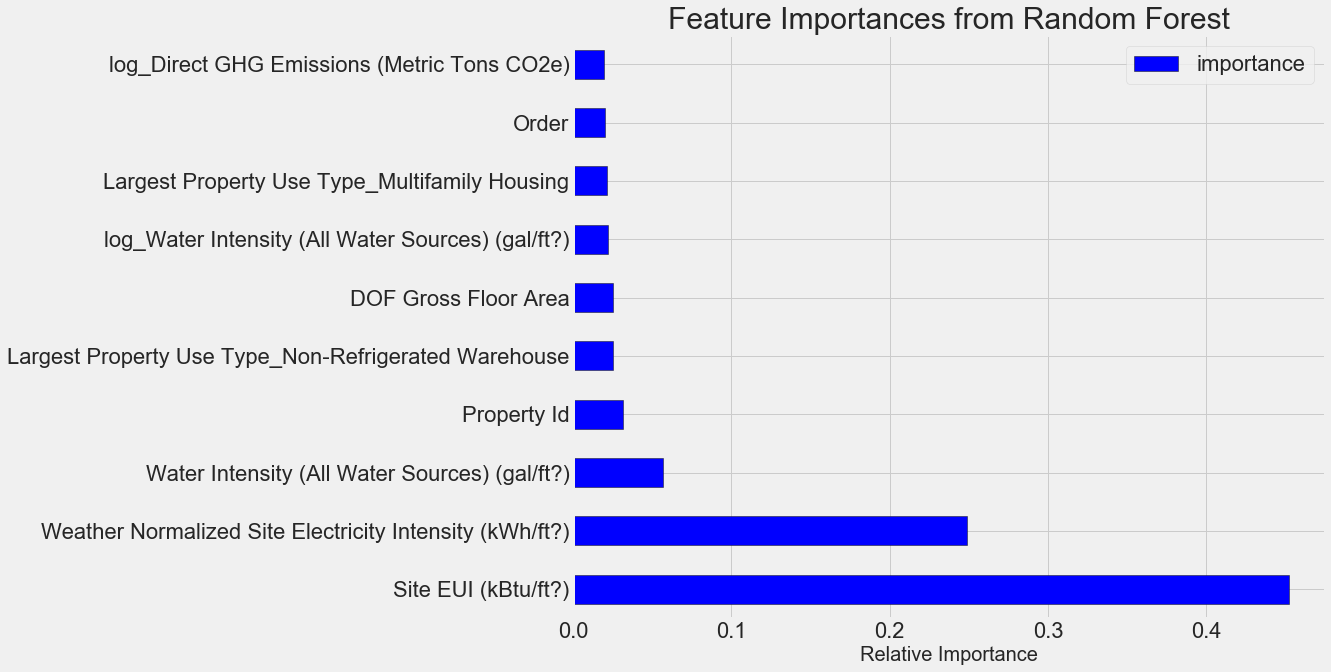

In [39]:
#Let's graph the feature importances to compare visually.
figsize(12, 10)
plt.style.use('fivethirtyeight')

# Plot the 10 most important features in a horizontal bar chart
feature_results.loc[:9, :].plot(x = 'feature', y = 'importance', 
                                 edgecolor = 'k',
                                 kind='barh', color = 'blue');
plt.xlabel('Relative Importance', size = 20); plt.ylabel('')
plt.title('Feature Importances from Random Forest', size = 30);

Самые важные признаки — Site EUI (интенсивность потребления энергии) и Weather Normalized Site Electricity Intensity, на них приходится больше 66 % суммарной важности. Уже у третьего признака важность сильно падает, это может говорить о том, что нам не нужно использовать все 64 признака для достижения высокой точности прогнозирования (в Jupyter notebook эта теория проверяется с использованием только 10 самых важных признаков, и модель оказалась не слишком точной).

На основе этих результатов можно наконец-то ответить на один из исходных вопросов: самыми важными индикаторами количества баллов Energy Star Score являются Site EUI и Weather Normalized Site Electricity Intensity. Не будем слишком углубляться в дебри важностей признаков, скажем лишь, что с них можно начать разбираться в механизме прогнозирования моделью.

Визуализация одного дерева решений

Осмыслить всю модель регрессии на основе градиентного бустинга тяжело, чего не скажешь об отдельных деревьях решений. Можно визуализировать любое дерево с помощью Scikit-Learn-функции export_graphviz. Сначала извлечём дерево из ансамбля, а затем сохраним его в виде dot-файла:

In [40]:
from sklearn import tree

# Extract a single tree (number 105)
single_tree = model.estimators_[105][0]

# Save the tree to a dot file
tree.export_graphviz(single_tree, out_file = 'tree.dot', feature_names = feature_list)

#С помощью визуализатора Graphviz преобразуем dot-файл в png, введя в командной строке:

#dot -Tpng tree.dot -o tree.png

#Получили полное дерево решений:

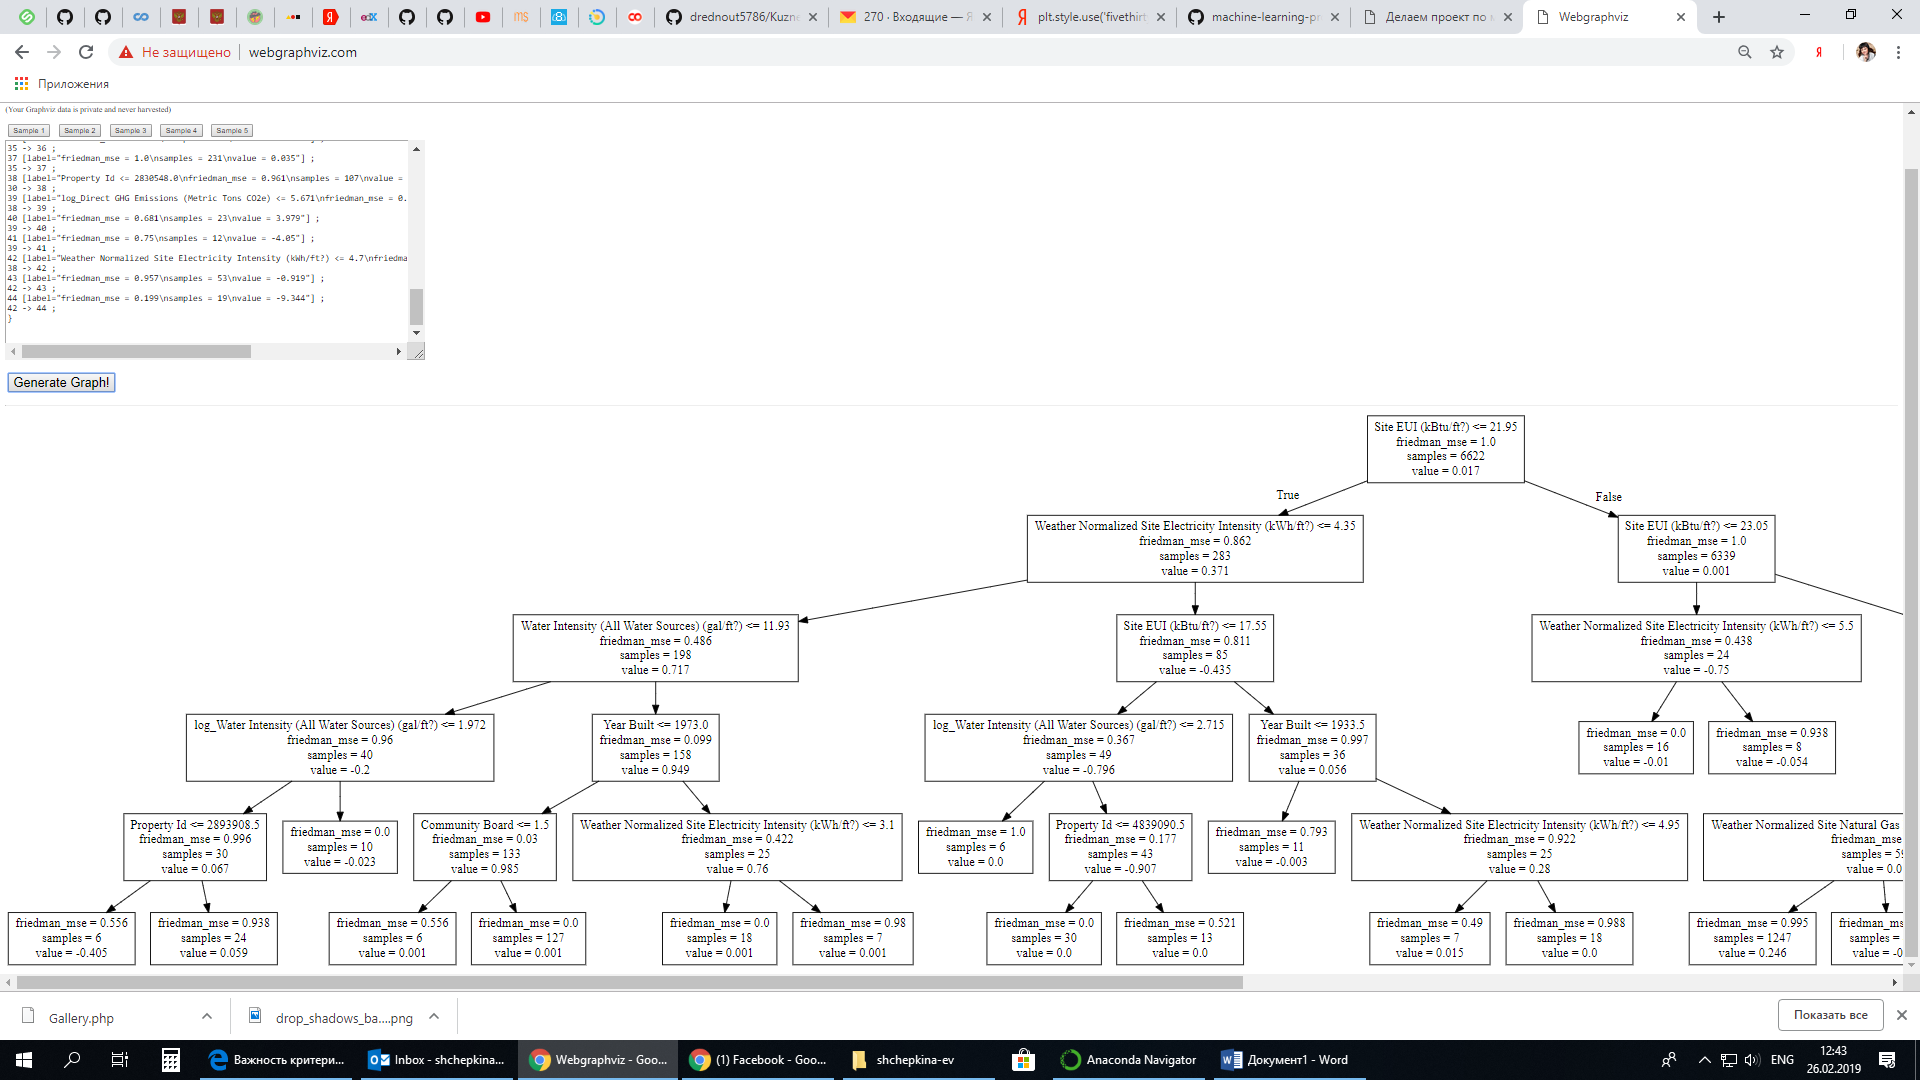

Каждый узел (прямоугольник) дерева содержит четыре строки:

Задаваемый вопрос о значении одного из признаков конкретного измерения: от него зависит, в какую сторону мы выйдем из этого узла.

Mse — мера ошибки в узле.

Samples — количество образцов данных (измерений) в узле.

Value — оценка цели для всех образцов данных в узле.

Отдельный узел.

(Листья содержат только 2.–4., потому что они представляют собой финальную оценку и не имеют дочерних узлов).

Формирование прогноза для заданного измерения в дереве решений начинается с верхнего узла — корня, а затем спускается вниз по дереву. В каждом узле нужно ответить на задаваемый вопрос «да» или «нет». Например, на предыдущей иллюстрации спрашивается: «Site EUI здания меньше или равно 68.95?» Если да, алгоритм переходит в правый дочерний узел, если нет, то в левый.

Эта процедура повторяется на каждом слое дерева, пока алгоритм не дойдёт до узла-листа на последнем слое (эти узлы не показаны на иллюстрации с уменьшенным деревом). Прогнозом для любого измерения в листе является value. Если в лист приходит несколько измерений (samples), то каждое из них получит один и тот же прогноз. По мере увеличения глубины дерева ошибка на обучающих данных будет уменьшаться, поскольку листьев будет больше и образцы будут делиться тщательнее. Однако слишком глубокое дерево приведёт к переобучению на обучающих данных и не сможет обобщить тестовые данные.

Во второй статье мы настроили количество гиперпараметров модели, которые управляют каждым деревом, например, максимальную глубину дерева и минимальное количество образцов, необходимых для каждого листа. Два этих параметра сильно влияют на баланс между пере- и недообучением, а визуализация дерева решений позволит нам понять, как работают эти настройки.

Хотя мы не сможем изучить все деревья в модели, анализ одного из них поможет разобраться в том, как прогнозирует каждый «ученик». Этот основанный на блок-схеме метод очень похож на то, как принимает решение человек. Ансамбли из деревьев решений комбинируют прогнозы многочисленных отдельных деревьев, что позволяет создавать более точные модели с меньшей вариативностью. Такие ансамбли очень точны и просты в объяснении.

Локальные интерпретируемые моделезависимые объяснения (LIME)

Последний инструмент, с помощью которого можно постараться разобраться в том, как «думает» наша модель. LIME позволяет объяснить, как сформирован одиночный прогноз любой модели машинного обучения. Для этого локально, рядом с каким-нибудь измерением на основе простой модели наподобие линейной регрессии создаётся упрощённая модель (подробности описаны в этой работе: https://arxiv.org/pdf/1602.04938.pdf).

Мы воспользуемся методом LIME, чтобы изучить совершенно ошибочный прогноз нашей модели и понять, почему она ошибается.

Сначала найдём этот неверный прогноз. Для этого обучим модель, сгенерируем прогноз и выберем значение с наибольшей ошибкой:

https://github.com/WillKoehrsen/machine-learning-project-walkthrough/blob/master/Machine%20Learning%20Project%20Part%203.ipynb https://itnan.ru/post.php?c=1&p=426771


# Изучим совершенно ошибочный прогноз нашей модели

In [41]:
from sklearn.ensemble import GradientBoostingRegressor

# Create the model with the best hyperparamters
model = GradientBoostingRegressor(loss='lad', max_depth=5, max_features=None, min_samples_leaf=6, min_samples_split=6, n_estimators=800, random_state=42)

# Fit and test on the features
model.fit(X, y)
model_pred = model.predict(X_test)

# Find the residuals
residuals = abs(model_pred - y_test)

# Extract the most wrong prediction
wrong = X_test[np.argmax(residuals), :]

print('Prediction: %0.4f' % np.argmax(residuals))
print('Actual Value: %0.4f' % y_test[np.argmax(residuals)])

Prediction: 1023.0000
Actual Value: 100.0000


Затем создадим объясняющий объект (explainer) и передадим ему обучающие данные, информацию о режиме, метки для обучающих данных и имена признаков. Теперь можно передать explainer’у данные наблюдений и функцию прогнозирования, а потом попросить объяснить причину ошибочности прогноза.


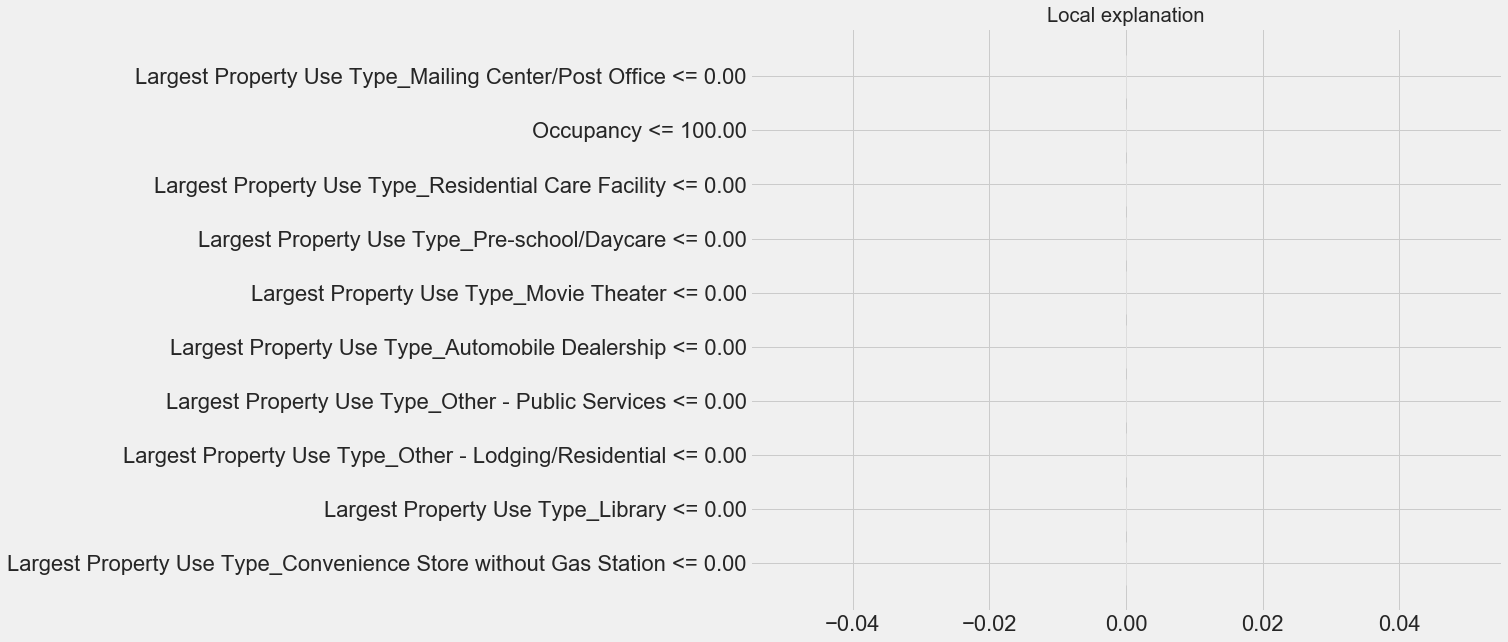

In [44]:
import lime 

# Create a lime explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = X, mode = 'regression', training_labels = y, feature_names = feature_list)


# Explanation for wrong prediction
exp = explainer.explain_instance(data_row = wrong, predict_fn = model.predict)

# Plot the prediction explaination
exp.as_pyplot_figure();

Как интерпретировать диаграмму: каждая запись по оси Y обозначает одно значение переменной, а красные и зелёные полосы отражают влияние этого значения на прогноз. Например, согласно верхней записи влияние Site EUI больше 95,90, в результате из прогноза вычитается около 40 пунктов. Согласно второй записи влияние Weather Normalized Site Electricity Intensity меньше 3,80, и поэтому к прогнозу прибавляется около 10 пунктов. Итоговый прогноз представляет собой сумму интерсепта и влияний каждого из перечисленных значений.

Давайте посмотрим на это с другой стороны и вызовем метод .show_in_notebook():

In [45]:
# Show the explanation in the Jupyter Notebook
exp.show_in_notebook()

Слева показан процесс принятия решения моделью: визуально отображено влияние на прогноз каждой переменной. В таблице справа приведены фактические значения переменных для заданного измерения.

В данном случае модель спрогнозировала около 12 баллов, а на самом деле было 100. Поначалу вы можете недоумевать, почему так произошло, но если проанализировать объяснение, то оказывается, что это не крайне смелое предположение, а результат расчёта на основе конкретных значений. Значение Site EUI было относительно высоким и можно было ожидать низкого балла Energy Star Score (потому что на него сильно влияет EUI), что наша модель и сделала. Но в данном случае эта логика оказалась ошибочной, потому что по факту здание получило наивысший балл Energy Star Score — 100.

Ошибки модели могут вас расстраивать, но подобные объяснения помогут понять, почему модель ошиблась. Более того, благодаря объяснениям можно начать раскапывать, почему здание получило высший балл несмотря на высокое значение Site EUI. Возможно, мы узнаем что-то новое о нашей задаче, что ускользнуло бы от нашего внимания, не начни мы анализировать ошибки модели. Подобные инструменты не идеальны, но они могут сильно облегчить понимание работы модели и принимать более правильные решения.

Документирование работы и представление результатов

Во многих проектах уделяется мало внимания документации и отчётам. Можно сделать лучший анализ в мире, но если не представить результаты должным образом, они не будут иметь значения! (http://blog.kaggle.com/2016/06/29/communicating-data-science-a-guide-to-presenting-your-work/)

Документируя проект по анализу данных, мы упаковываем все версии данных и код, чтобы проект могли воспроизвести или собрать другие люди. Помните, что код читают чаще, чем пишут, поэтому наша работа должна быть понятна и другим людям, и нам, если мы вернёмся к ней через несколько месяцев. Поэтому вставляйте в код полезные комментарии и объясняйте свои решения. Блокноты Jupyter Notebook — прекрасный инструмент для документирования, они позволяют сначала объяснять решения, а потом показывать код.

Также Jupyter Notebook хорошая платформа для взаимодействия с другими специалистами. С помощью расширений для блокнотов можно скрыть код из финального отчёта, поскольку, как бы вам ни было трудно в это поверить, не все хотят видеть кучу кода в документе! (https://github.com/kirbs-/hide_code)

Возможно, вам захочется не делать выжимку, а показать все подробности. Однако важно понимать свою аудиторию, когда представляешь свой проект, и соответствующим образом составить отчёт. Вот пример краткого изложения сути нашего проекта:

С помощью данных об энергопотреблении зданий в Нью-Йорке можно построить модель, прогнозирующую количество баллов Energy Star Score с погрешностью в пределах 9,1 пункта.
Site EUI и Weather Normalized Electricity Intensity — главные факторы, влияющие на прогноз.

Подробное описание и выводы мы написали в Jupyter Notebook, но вместо PDF преобразовали в Latex .tex-файл, который затем отредактировали в texStudio, и получившийся вариант преобразовали в PDF. Дело в том, что результат экспорта по умолчанию из Jupyter в PDF выглядит вполне прилично, но его можно сильно улучшить всего за несколько минут редактирования. К тому же Latex — мощная система подготовки документов, которой полезно владеть.

В конечном счёте, ценность нашей работы определяется решениями, которые она помогает принять, и очень важно уметь «подать товар лицом». Правильно документируя, мы помогаем другим людям воспроизвести наши результаты и дать нам обратную связь, что позволит нам стать опытнее и в дальнейшем опираться на полученные результаты.

Выводы

В нашей серии публикаций мы разобрали от начала до конца учебный проект по машинному обучению. Начали с очистки данных, затем создали модель, и в конце научились её интерпретировать. Напомним общую структуру проекта по машинному обучению:

Очистка и форматирование данных.
Разведочный анализ данных.
Конструирование и выбор признаков.
Сравнение метрик нескольких моделей машинного обучения.
Гиперпараметрическая настройка лучшей модели.
Оценка лучшей модели на тестовом наборе данных.
Интерпретирование результатов работы модели.
Выводы и хорошо задокументированный отчёт.

Набор этапов может меняться в зависимости от проекта, и машинное обучение зачастую процесс итеративный, а не линейный, так что это руководство поможет вам в будущем. Надеемся, вы теперь сможете уверенно реализовать свои проекты, но помните: никто не действует в одиночку! Если вам нужна помощь, есть множество очень полезных сообществ, где вам дадут советы.

Эти источники могут помочь вам:

Hands-On Machine Learning with Scikit-Learn and Tensorflow (Jupyter Notebook для этой книги доступны для скачивания бесплатно)!
An Introduction to Statistical Learning
Kaggle: The Home of Data Science and Machine Learning
Datacamp: хорошие руководства для практики в программировании анализа данных.
Coursera: бесплатные и платные курсы по многим темам.
Udacity: платные курсы по программированию и анализу данных.